<b>Notes<b><br/>
    
A B testing is a powerful statistical method to evaluate the effect of changes in an experiment
Can be applied against algorithm, product, feature
Control - Current version and Experimental/Treatment group - New version

A B testing is reliable because it obtains direct feedback from consumers

Steps:
Define Hypothesis and primary success metric
Designing the experiement and Power Analysis - sample size to claim minimum statistical significance
Run the A B test - Here we collect the data from our experiment
Choosing the statistical test - Z-test, T-test, Chi-Square test or One-tailed, Two-tailed test
Check statistical significance in difference between the groups
CTR(Click through rate) - as engagement metric, conversion rates for revenue metrics
CTA - Call to Action
Desired results - alternative hypothesis


Power Analysis - Assume values for significance level (Alpha), power of test (1 - Beta)
Calculate minimum Sample size
Determine Test duration


Power - Probability of correctly rejecting null hypothesis - affects Type II error rate (False Negatives)
In other words, correctly identify change effects with (1 - B) probability. Commonly set to 80% (Allows 20% type II error, meaning we may fail to identify the change effects 20% of the time)

Statistical Significance - Alpha. Type I error rate, probability of correctly rejecting the null (False positive)
(Only detects changes with high percentage of confidence (90, 95 or 99%, for alpha of 10, 5, and 1%)
(Surity in our discovering increases with decrease in alpha)


Minimum detectable effect - (or desired effect from a change) (delta)


Calculating minimum sample size
without min size p- hacking

Duration of test - (Time taken to achieve sample size data). Sample Size / Number of consumer experiment is applied on daily
Note: Carefully consider, holidays, shopping activity in time period (like festivals, etc)...
Small test duration can cause novelty effect - people generally react quickly and positive to changes in the beginning
Long test duration can cause maturation effect - people get used to the changes


control_p = Success_control / N_control
exp_p = Success_exp / N_exp

p_ = Success/ Total N (N_exp + N_control)

variance_p = p_ * (1 - p_) * (1 / N_exp + 1 / N_control)
SE = sqrt (variance_p)

Find critical value and compare (control_p - exp_p) / SE

In [1]:
# Import required packages
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
# Sample code here will skip power analysis and assume a sample size of 10k. 
N_exp = 10000
N_con = 10000
# For the sample we will skip the collection of data and assume the web events follow a binomial distribution
click_exp = pd.Series(np.random.binomial(1,0.5,size = N_exp))
click_con = pd.Series(np.random.binomial(1,0.2,size = N_con))

exp_id = pd.Series(np.repeat("exp", N_exp))
con_id = pd.Series(np.repeat("con", N_con))

df_exp = pd.concat([click_exp,exp_id],axis = 1)
df_con = pd.concat([click_con,con_id],axis = 1)

df_exp.columns = ["click", "group"]
df_con.columns = ["click", "group"]

df_ab_test = pd.concat([df_exp, df_con], axis=0).reset_index(drop=True)
# Data will have 20k rows with 10k each for control and experiment groups
df_ab_test

,click,group
0,0,exp
1,0,exp
2,1,exp
3,1,exp
4,1,exp
...,...,...
19995,0,con
19996,0,con
19997,0,con
19998,0,con


In [3]:
# Choose a significance level
alpha = 0.05

In [4]:
# Get the probability of success event for each group
p_exp_hat, p_con_hat = df_ab_test.groupby("group")["click"].mean().loc[["exp", "con"]].tolist()
p_overall_hat = df_ab_test.click.mean()

print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)
print('Click probability overall:', p_overall_hat)

Click Probability in Control Group: 0.2103
Click Probability in Experimental Group: 0.499
Click probability overall: 0.35465


In [5]:
# Calculate the standard error
overall_variance = p_overall_hat * (1 - p_overall_hat) * ((1 / N_exp) + (1 / N_con))

SE = np.sqrt(overall_variance)
print("Standard Error is: ", SE)

Standard Error is:  0.006765698448793


In [6]:
test_statistic = (p_con_hat - p_exp_hat) / SE
print("Test Statistics for 2-sample Z-test is:", test_statistic)

Test Statistics for 2-sample Z-test is: -42.671130288330254


In [7]:
# For a 2-tailed test take alpha / 2 regions on both sides of tail instead of alpha no one side.
# Note: Since we are checking for the equality this is a 2-tailed test
# The ppf function is equivalent to the inverse cdf (cumulative distribution function)
critical_value = norm.ppf(1 - alpha)
print("Z-critical value from Standard Normal distribution: ", critical_value)

# Calculate the p value of our test_statistic
p_value = 2 * norm.sf(abs(test_statistic))
print("P-value of the 2-sample Z-test: ", round(p_value, 3))

Z-critical value from Standard Normal distribution:  1.6448536269514722
P-value of the 2-sample Z-test:  0.0


In [8]:
# The p-value of < alpha shows that the control and experiment groups are different

In [9]:
# Calculate the confidence interval to check the range of values for detecting the effect
CI = [round((p_exp_hat - p_con_hat) - SE * critical_value, 3), round((p_exp_hat - p_con_hat) + SE * critical_value, 3)]
print("Confidence Interval of the 2 sample Z-test is: ", CI)

Confidence Interval of the 2 sample Z-test is:  [0.278, 0.3]


In [10]:
def plot_AB_test(test_statistic, critical_value):
    import matplotlib.pyplot as plt

    # Parameters for the standard normal distribution
    mu = 0  # Mean
    sigma = 1  # Standard deviation
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    y = norm.pdf(x, mu, sigma)

    # Plotting the standard normal distribution
    plt.plot(x, y, label = 'Standard Normal Distribution')

    # Shade the rejection region for a two-tailed test
    plt.fill_between(x, y, where = (x > critical_value) | (x < -critical_value), 
                                 color = 'red', alpha = 0.5, label = 'Rejection Region')

    # Adding Test Statistic
    plt.axvline(test_statistic, color = 'green', linestyle = 'dashed', linewidth = 2, 
                        label = f'Test Statistic = {test_statistic : .2f}')

    # Adding Z-critical values
    plt.axvline(critical_value, color = 'blue', linestyle = 'dashed', linewidth = 1, 
                        label = f'Z-critical = {critical_value : .2f}')
    plt.axvline(-critical_value, color = 'blue', linestyle = 'dashed', linewidth = 1)

    # Adding labels and title
    plt.xlabel('Z-value')
    plt.ylabel('Probability Density')
    plt.title('Gaussian Distribution with Rejection Region')
    plt.legend()

    # Show plot
    plt.show()

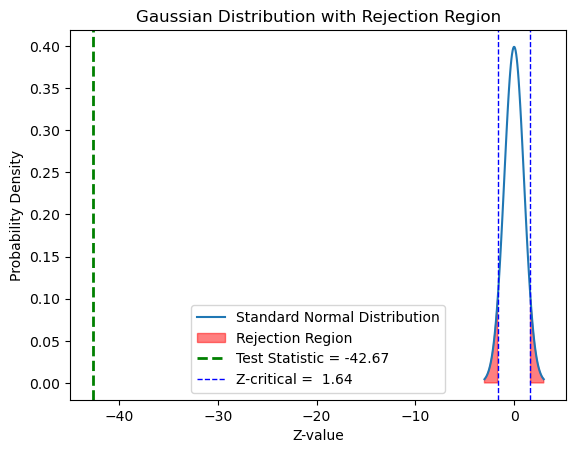

In [11]:
plot_AB_test(test_statistic, critical_value)